# Kelly Criterion and Optimal Growth Portfolios

The Kelly Criterion determines the size of a bet in a repeated game with binary outcomes. The analysis was proposed in 1956 by John Kelly at Bell Laboratories. Kelly identified an analogy between gambling on binary outcomes and Claude Shannon's work on encoding information for transmission on noisy channels. Kelly used the analogy to show

> The maximum exponential rate of growth of he gambler's capital is equal to the rate of transmission of information over the channel.

This idea actually predates Kelly. In 1738, for instance, Daniel Bernoulli offered a resolution to the St. Petersburg paradox previously proposed by his cousin, Nicholas Bernoulli. The resolution was to allocate bets among investments to produce the the highest geometric mean of returns. As popularized by William Poundstone in his book "Fortune's Formula", Kelly's analysis was quickly picked up by gamblers with colorful adventures in Las Vega by early adopters, but the result laid in obscurity among investors until much later.

Among the reasons why Kelly was neglected by investors were high profile critiques by the most famous economist of the 20th Century, Paul Samuelson. Samuelson objected on several grounds, among them is a lack of risk aversion that results in large bets and risky short term behavior, and that Kelly's result is applicable to only one of many utility functions that describe investor preferences. The controversy didn't end there, however, as other academic economists, including Harry Markowitz, and practitioners found ways to adapt the Kelly criterion to investment funds.

This notebook presents solutions to Kelly's problem and related applications the using exponential cones. A significant feature of this notebook is the the inclusion of a risk constraints recently proposed by Boyd and coworkers. These notes are based on recent papers such as Cajas (2021), Busseti, Ryu and Boyd (2016), Fu, Narasimhan, and Boyd (2017) and applied to examples presented by Luenberger (1999, 2013), and others. Additional bibliographic notes are provided at the end of the notebook.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_mosek()

pyomo was previously installed
mosek was previously installed


## Optimal Log Growth

The problem addressed by Kelly is to maximize the rate of growth of an investor's wealth. At each stage, the gross return $R_n$ on the investor's wealth $W_n$ is given by

$$W_n = W_{n-1} R_n $$

After $N$ stages

$$
\begin{align}
W_N & = W_0 R_1 R_2 \cdots R_{N-1} R_N  \\
W_N & = W_0 \prod_{n=1}^N R_n
\end{align}
$$

Kelly's idea was to maximize the mean log return. Intuitively, this objective can be justified as either maximizing the geometric mean return

$$\left(\prod_{n=1}^N R_n\right)^{\frac{1}{N}} = \exp\left(\frac{1}{N}\sum_{n=1}^N \log R_n\right)$$

or by maximizing the expected logarithmic utility of wealth in 

$$
\begin{align}
\log W_N & = \log W_0 \left(\sum_{n=1}^N \log R_n\right) 
\end{align}
$$

Logarithmic utility provides an element of risk aversion. If the returns are independent and identically distributed random variable, then in the long run, 

$$
\begin{align}
\mathbb{E}[\log W_N] & = \log W_0\ \mathbb{E}[\log R]
\end{align}
$$

the optimal log growth return will almost surely result in higher wealth than any other policy.

## Kelly's Criterion

### Modeling

The classical presentation of the Kelly Criterion is to consider repeated wagers on a gambling proposition. For each stage, a wager of one unit returns $1+b$ with probability $p$ if successful, otherwise returns nothing. The problem is to determine what fraction of the gambler's wealth should be wagered at each stage.

Let $w$ be the fraction of wealth that is wagered at each stage. The two possible outcomes at stage $k$ are

$$
\begin{align}
W_k = \begin{cases} 
(1 + bw) W_{k-1} && \text{probability } p\\
(1 - w) W_{k=1} && \text{probability }1-p
\end{cases}
\end{align}
$$

The gross returns are 

\begin{align}
R_k = \begin{cases}
1 + b w & \text{probability }p \\
1 - w & \text{probability }1-p \\
\end{cases}
\end{align}

Given these outcomes, the objective is to the maximize the expected log return

$$
\begin{align}
\max_{w\geq 0} p \log (1 + bw) + (1-p) \log (1 - w) \\
\end{align}
$$

The analytical solution to this problem is

$$w^{opt} = p - \frac{1-p}{b}$$

We can use this analytical solution to validate a solution to this problem using conic programming. An exponential cone is a convex set $K_{exp} = \{(r, x, y)\}$ such that

$$r \geq x \exp{\frac{y}{x}}$$ 

where $r, x \geq 0$. Taking the exponential of the terms in the objective function, 

$$q_1 \leq \log (1 + bw) \iff \exp{q_1} \leq 1 + b w \iff (1 + bw, 1, q_1) \in K_{exp}$$

and

$$q_2 \leq \log (1 - w) \iff \exp{q_2} \leq 1 - w \iff (1 - w, 1, q_2) \in K_{exp}$$ 

With these constraints, Kelly's problem becomes

$$
\begin{align}
\max\quad & p q_1 + (1-p)q_2 \\
\text{s.t.}\quad & w \geq 0 \\
& (1 + bw, 1, q_1) \in K_{exp} \\
& (1 - w, 1, q_2) \in K_{exp}
\end{align}
$$

The following cell demonstrates the solution using the conic programming functions of the Pyomo kernel library and the Mosek solver.


In [2]:
import pyomo.kernel as pmo

# parameter values
b = 2
p = 0.51

# conic programming solution to Kelly's problem 
def kelly(p, b):

    m = pmo.block()

    # decision variables
    m.q1 = pmo.variable()
    m.q2 = pmo.variable()
    m.w = pmo.variable(lb=0)

    # objective
    m.ElogR = pmo.objective(p*m.q1 + (1-p)*m.q2, sense=pmo.maximize)

    # conic constraints
    m.t1 = pmo.conic.primal_exponential.as_domain(1 + b*m.w, 1, m.q1)
    m.t2 = pmo.conic.primal_exponential.as_domain(1 - m.w, 1, m.q2)

    # solve with 'mosek_direct' (conic) or 'ipopt' (nonlinear)
    pmo.SolverFactory('mosek_direct').solve(m)

    return m.w()

w_conic = kelly(p, b)
print(f"Conic programming solution = {w_conic: 0.4f}")

# analytical solution to Kelly's problem
w_analytical = p - (1 - p)/b
print(f"Analytical solution = {w_analytical: 0.4f}")

Conic programming solution =  0.2650
Analytical solution =  0.2650


### Risk-Constraints and Kelly Criterion

Following Busseti, Ryu, and Boyd (2016), for the risk-constrained case we add a constraint

$$\mathbb{E}[R^{-\lambda}] \leq 1$$

where $\lambda \geq 0$ is a risk-aversion parameter. For the case considered here, there are two outcomes with known probabilities so this becomes

$$p_1 R_1^{-\lambda} + p_2 R_2^{-\lambda} \leq 1$$

When $\lambda=0$ the constraint is always satisfied and no risk-aversion is in effect. Choosing $\lambda > 0$ requires outcomes with low return to occur with low probability, the the effect increasing for larger values of $\lambda$.    There is always a feasible solution found by setting the bet size $w=0$ which gives $R_1 = 1$ and $R_2 = 0$.

This constraint can be reformulated using exponential cones. Rewriting each term as an exponential results gives

$$e^{\log(p_1) - \lambda\log(R_1)}  + e^{\log(p_2) - \lambda\log(R_2)} \leq 1$$

We previously introduced variables $q_i \leq \log(R_i)$, so a new version of the risk constraint is

$$e^{\log(p_1) - \lambda q_1}  + e^{\log(p_2) - \lambda q_2} \leq 1$$

Introducing $u_i \geq e^{\log(p_i) - \lambda q_i}$, the risk constraint is given by

$$
\begin{align}
u_1 + u_2 & \leq 1 \\
(u_1, 1, \log(p_1) - \lambda q_1) & \in K_{exp} \\
(u_2, 1, \log(p_2) - \lambda q_2) & \in K_{exp}
\end{align}
$$

Putting this all together, given probability $p$, odds $b$, and risk-aversion parameter $\lambda \geq 0$, the risk-constrained Kelly bet is a solution to the conic program

$$
\begin{align}
\max\quad & p q_1 + (1-p)q_2 \\
\text{s.t.}\quad & w \geq 0 \\
& (1 + bw, 1, q_1) \in K_{exp} \\
& (1 - w, 1, q_2) \in K_{exp} \\
& u_1 + u_2 \leq 1 \\
& (u_1, 1, \log(p_1) - \lambda q_1) \in K_{exp} \\
& (u_2, 1, \log(p_2) - \lambda q_2) \in K_{exp} 
\end{align}
$$

The following cell solves this problem with a Pyomo model using the Mosek solver.

In [3]:
import pyomo.kernel as pmo
import numpy as np

# parameter values
b = 2
p = 0.51
lambd = 2

# conic programming solution to Kelly's problem 
def kelly_rck(p, b, lambd):

    m = pmo.block()

    # decision variables
    m.q1 = pmo.variable()
    m.q2 = pmo.variable()
    m.w = pmo.variable(lb=0)

    # objective
    m.ElogR = pmo.objective(p*m.q1 + (1-p)*m.q2, sense=pmo.maximize)

    # conic constraints
    m.t1 = pmo.conic.primal_exponential.as_domain(1 + b*m.w, 1, m.q1)
    m.t2 = pmo.conic.primal_exponential.as_domain(1 - m.w, 1, m.q2)
    
    # risk constraints
    m.u1 = pmo.variable(lb=0)
    m.u2 = pmo.variable(lb=0)
    m.r0 = pmo.constraint(m.u1 + m.u2 <= 1)
    m.r1 = pmo.conic.primal_exponential.as_domain(m.u1, 1, np.log(p) - lambd*m.q1)
    m.r2 = pmo.conic.primal_exponential.as_domain(m.u2, 1, np.log(1 - p) - lambd*m.q2)

    # solve with 'mosek_direct' (conic) or 'ipopt' (nonlinear)
    pmo.SolverFactory('mosek_direct').solve(m)

    return m.w()

# solution to Kelly's problem
w_analytical = p - (1 - p)/b
print(f"Analytical Solution = {w_analytical: 0.4f}")

w_rck = kelly_rck(p, b, lambd)
print(f"Risk Constrainend Solution = {w_rck: 0.4f}")

Analytical Solution =  0.2650
Risk Constrainend Solution =  0.1753


### Simulation

The following cells simulate the performance of the Kelly Criterion both with and without risk constraints. Compare the cases by comparing the log mean growth, which is reduced by presence of risk constraints, and the portfolio draw down for the most pathological cases, which is improved by the presence of risk constraints.

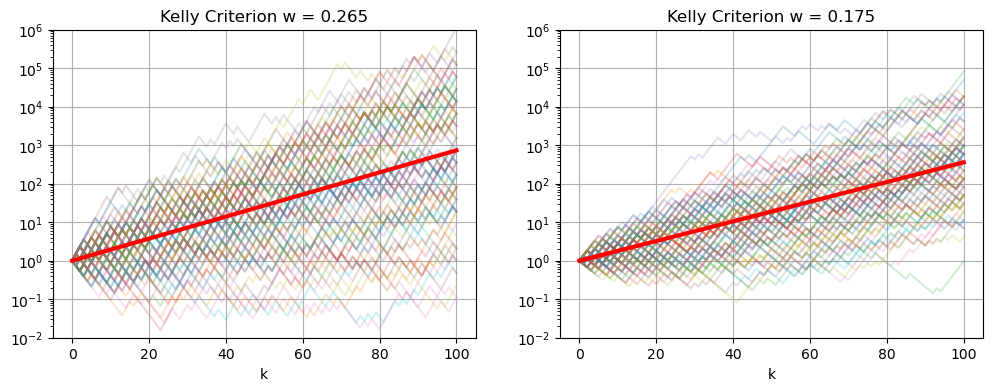

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform

def kelly_sim(p, b, w, K=None, ax=None):
    m = p*np.log((1 + b*w)) + (1 - p)*np.log((1 - w))    
    if K is None:
        K = int(np.log(2)/m)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    # monte carlo simulation and plotting
    for n in range(0, 100):
        W = [1]
        for k in range(0,K):
            if uniform() <= p:
                W.append(W[-1]*(1 + w*b))
            else:
                W.append(W[-1]*(1 - w))
        ax.semilogy(W, alpha=0.2)

    ax.semilogy(np.linspace(0,K), np.exp(m*np.linspace(0,K)), 'r', lw=3)  
    ax.set_title(f'Kelly Criterion w = {w:0.3f}')
    ax.set_xlabel('k')
    ax.grid(True)
    ax.set_ylim(0.01, 1e6)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
kelly_sim(p, b, kelly(p, b), 100, ax[0])

lambd=2
kelly_sim(p, b, kelly_rck(p, b, lambd), 100, ax[1])

## Luenberger's Investment Wheel

### Problem Statement

In Chapter 18 of his book "Investment Science", David Luenberger presents an "investment" wheel with multiple outcomes. The wheel is divided into sectors, each marked with a number. An investor can place a wager on each sector before the spin of the wheel.  After the wheel comes to rest, the investor receives a payout equal to the wager times the number that appears next to the marker. The game can be repeated any number of times.

![](investment-wheel.png)

Given an initial wealth $W_0$, what is your investing strategy for repeated plays of the game?

* Is there an investing strategy that almost surely grows? 
* What is the mean return for each spin of the wheel?

### Modeling

The investment wheel is an example of a game with $n=3$ outcomes. For each outcome $n$ there is a payout $b_n$ that occurs with probability $p_n$ as shown in the following table.

| Outcome | Probability $p_n$ | Odds $b_n$ |
| :--: | :--: | :--: |
| A | 1/2 | 3 |
| B | 1/3 | 2 |
| C | 1/6 | 6 |

If a fraction of wealth $w_n$ is wagered on each outcome $n$, then the gross returns are given in the following table.

| Outcome | Probability $p_n$ | Gross Returns $R_n$ |
| :--: | :--: | :--: |
| A | 1/2 | 1 + 2$w_A$ - $w_B$ - $w_C$ |
| B | 1/3 | 1 - $w_A$ + $w_B$ - $w_C$ |
| C | 1/6 | 1 - $w_A$ - $w_B$ + 5$w_C$ |

For a general game with $n$ outcomes,the optimization problem is to maximize expected log return 

$$
\begin{align}
\max_{w \geq 0}\quad & \sum_{n\in N} p_n \log(R_n) \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
\end{align}
$$


Reformulation of the objective function with exponential cones gives a conic program.

$$
\begin{align}
\max_{w\geq 0}\quad & \sum_{n\in N} p_n q_n \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
& (R_n, 1, q_n) \in K_{exp} & \forall n \in N \\
\end{align}
$$

The solution of this program is shown below.

In [5]:
# describe the betting wheel
sectors = {
    "A": {"p": 1/2, "b": 3},
    "B": {"p": 1/3, "b": 2},
    "C": {"p": 1/6, "b": 6},
}

In [6]:
import pyomo.kernel as pmo

def wheel(sectors):

    m = pmo.block()
    
    S = sectors.keys()

    # decision variables
    m.w = pmo.variable_dict({s: pmo.variable(lb=0) for s in S})
    m.q = pmo.variable_dict({s: pmo.variable() for s in S})
    
    # objective
    m.ElogR = pmo.objective(sum(sectors[s]["p"]*m.q[s] for s in S), sense=pmo.maximize)
    
    # expression for returns
    m.R = pmo.expression_dict({s: pmo.expression(1 + sectors[s]["b"]*m.w[s] - sum(m.w[s] for s in S)) for s in S})
    
    # constraints
    m.sum_w = pmo.constraint(sum(m.w[s] for s in S) <= 1)
    m.conic = pmo.block_dict({s: pmo.conic.primal_exponential.as_domain(m.R[s], 1, m.q[s]) for s in S})

    # solve with 'mosek_direct' (conic) or 'ipopt' (nonlinear)
    pmo.SolverFactory('mosek_direct').solve(m)

    return m
        
m = wheel(sectors)

print(f"Expected Gross Return = {np.exp(m.ElogR()): 0.5f}\n")
for s in sectors.keys():
    print(f"Sector {s}:  p = {sectors[s]['p']:0.4f}   b = {sectors[s]['b']:0.2f}   w = {m.w[s]():0.5f}")

Expected Gross Return =  1.06991

Sector A:  p = 0.5000   b = 3.00   w = 0.42322
Sector B:  p = 0.3333   b = 2.00   w = 0.21814
Sector C:  p = 0.1667   b = 6.00   w = 0.12826


### Risk Constraints

For the risk constrained case, we consider a constraint

$$\mathbb{E}[R^{-\lambda}] \leq 1$$

where $\lambda$ is a risk aversion parameter.

$$\sum_{n\in N} p_n R_n^{-\lambda} \leq 1$$

Again

$$\sum_{n\in N} e^{\log(p_1) - \lambda\log(R_1)} \leq 1$$

Introducing $u_n \geq e^{\log(p_n) - \lambda q_n}$ using the $q_n$ defined above, we get

$$
\begin{align}
\sum_{n\in N} u_n & \leq 1 \\
(u_n, 1, \log(p_n) - \lambda q_n) & \in K_{exp} & \forall n\in N \\
\end{align}
$$

The risk-constrained investment wheel is now


$$
\begin{align}
\max_{w\geq 0}\quad & \sum_{n\in N} p_n q_n \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
&\sum_{n\in N} u_n  \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
& (R_n, 1, q_n) \in K_{exp} & \forall n \in N \\
& (u_n, 1, \log(p_n) - \lambda q_n) \in K_{exp} & \forall n\in N \\
\end{align}
$$


In [7]:
import pyomo.kernel as pmo

def wheel_rsk(sectors, lambd=0):

    m = pmo.block()
    
    S = sectors.keys()

    # decision variables
    m.w = pmo.variable_dict({s: pmo.variable(lb=0) for s in S})
    m.q = pmo.variable_dict({s: pmo.variable() for s in S})
    
    # objective
    m.ElogR = pmo.objective(sum(sectors[s]["p"]*m.q[s] for s in S), sense=pmo.maximize)
    
    # expression for returns
    m.R = pmo.expression_dict({s: pmo.expression(1 + sectors[s]["b"]*m.w[s] - sum(m.w[s] for s in S)) for s in S})
    
    # constraints
    m.sum_w = pmo.constraint(sum(m.w[s] for s in S) <= 1)
    m.conic = pmo.block_dict({s: pmo.conic.primal_exponential.as_domain(m.R[s], 1, m.q[s]) for s in S})
    
    # risk constraints
    m.u = pmo.variable_dict({s: pmo.variable() for s in S})
    m.sum_u = pmo.constraint(sum(m.u[s] for s in S) <= 1)
    m.risk =  pmo.block_dict(
        {s: pmo.conic.primal_exponential.as_domain(m.u[s], 1, np.log(sectors[s]["p"]) - lambd*m.q[s]) for s in S}
    )

    # solve with 'mosek_direct' (conic) or 'ipopt' (nonlinear)
    pmo.SolverFactory('mosek_direct').solve(m)

    return m
        
m = wheel_rsk(sectors, 5)

print(f"Expected Gross Return = {np.exp(m.ElogR()): 0.5f}\n")
for s in sectors.keys():
    print(f"Sector {s}:  p = {sectors[s]['p']:0.4f}   b = {sectors[s]['b']:0.2f}   w = {m.w[s]():0.5f}")
    

Expected Gross Return =  1.03873

Sector A:  p = 0.5000   b = 3.00   w = 0.30461
Sector B:  p = 0.3333   b = 2.00   w = 0.31715
Sector C:  p = 0.1667   b = 6.00   w = 0.12435


### Effect of Risk Aversion

The following cell demonstrates the effect of increasing the risk aversion parameter $\lambda$.

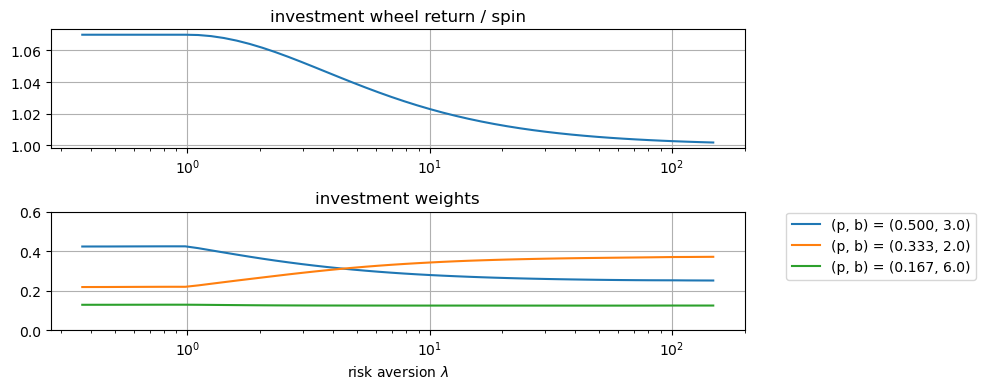

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(10, 4))

v = np.linspace(-1, 5)
lambd = np.exp(v)
results = [wheel_rsk(sectors, _) for _ in lambd]

ax[0].semilogx(lambd, [np.exp(m.ElogR()) for m in results])
ax[0].set_title('investment wheel return / spin')
ax[0].grid(True)

ax[1].semilogx(lambd, [[m.w[s]() for s in sectors.keys()] for m in results])
ax[1].set_title('investment weights')
ax[1].set_xlabel('risk aversion $\lambda$')
ax[1].legend([f"(p, b) = ({sectors[s]['p']:0.3f}, {sectors[s]['b']:0.1f})" for s in sectors.keys()],
            bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, 0.6)

fig.tight_layout()

### Exercises

1. Is there a deterministic investment strategy for the investment wheel?. That is, is there investment strategy that provides a fixed return regardless of the outcome of the spin? Set up and solve a model to find that strategy.

2. Find the variance in the outcome of the wheel, and plot the variance as a function of the risk aversion parameter $\lambda$. What is the relationship of variance and $\lambda$ in the limit as $\lambda \rightarrow 0$? See the paper by Busseti, E., Ryu, E. K., & Boyd, S. (2016) for ideas on how to perform this analysis.

## Portfolio Design for Optimal Growth

### Model

Given the models developed for the examples above, we now consider a set $N$ of financial assets trading in efficient markets. The historical record consists of a matrix $R \in \mathbb{R}^{T\times N}$ of gross returns where $T$ is the set of observations. The weights $w_n \geq 0$ for $n\in N$ denote the fraction of the portfolio invested in each asset $n$. Any portion of the portfolio not invested in traded assets is assumed to have a gross risk-free return $R_f = 1 + r_f$ where $r_f$ is the return on a risk-free asset.

Assuming the gross returns are independent and identically distributed random variates representative of future returns, the investment model becomes

$$
\begin{align}
\max_{w_n \geq 0}\quad & \frac{1}{T} \sum_{t\in T} \log(R_t) \\
\text{s.t.}\quad \\
& R_t = R_f + \sum_{n\in N} w_n (R_{t, n} - R_f) & \forall t\in T\\
\end{align}
$$

Note this formulation allows the sum of weights $\sum_{n\in N} w_n$ to be greater than one. In that case the investor would be investing more than the value of the portfolio in traded assets. In other words the investor would be creating a leveraged portfolio by borrowing money at a rate $R_f$. 

$$\sum_{n\in N} w_n \leq E_M$$

where $E_M$ is the "equity multiplier." A value $E_M \leq 1$ restricts the total investment to be less than or equal to the equity available to the investor. A value $E_M > 1$ allows the investor to leverage the available equity by borrowing money at a gross rate $R_f = 1 + r_f$. 

Using techniques demonstrated in the examples above, this model can be reformulated with exponential cones.

$$
\begin{align}
\max_{w_n}\quad & \frac{1}{T} \sum_{t\in T} q_t \\
\text{s.t.}\quad \\
& (R_f + \sum_{n\in N}w_n (R_{t,n} - R_f), 1, q_t) \in K_{exp} & \forall t \in T \\
& \sum_{n\in N} w_n \leq E_M \\
& w_n \geq 0  & \forall n\in N \\
\end{align} 
$$

For the risk constrained case, we consider a constraint

$$\mathbb{E}[R^{-\lambda}] \leq R_f^{-\lambda}$$

where $\lambda$ is a risk aversion parameter. Assuming the historical returns are equiprobable 

$$\frac{1}{T} \sum_{t\in T} R_t^{-\lambda} \leq R_f^{-\lambda}$$

The risk constraint is satisfied for any $w_n$ if the risk aversion parameter $\lambda=0$. For any value $\lambda > 0$ the risk constraint has a feasible solution $w_n=0$ for all $n \in N$. Recasting as a sum of exponentials,

$$\frac{1}{T} \sum_{t\in T} e^{- \lambda\log(R_t)} \leq R_f^{-\lambda}$$

Using the $q_t \leq \log(R_t)$ as used in the examples above, and $u_t \geq e^{- \lambda q_t}$, we get the risk constrained model optimal log growth. 

Given a risk-free rate of return $R_f$, a maximum equity multiplier $E_M$, and value $\lambda \geq 0$ for the risk aversion, risk constrained Kelly portfolio is given the solution to

$$
\begin{align}
\max_{w_n, q_t, u_t}\quad & \frac{1}{T} \sum_{t\in T} q_t \\
\text{s.t.}\quad \\
& \frac{1}{T} \sum_{t\in T} u_t \leq R_f^{-\lambda} \\
& (u_t, 1, \lambda q_t) \in K_{exp} & \forall t\in T \\
& (R_f + \sum_{n\in N}w_n (R_{t,n} - R_f), 1, q_t) \in K_{exp} & \forall t \in T \\
& \sum_{n\in N} w_n \leq E_M \\
& w_n \geq 0 & \forall n \in N \\
\end{align}
$$

The following cells demonstrate an implementation of the model using the Pyomo kernel library and Mosek solver.

### Data set

We begin by reading recennt historical prices for a selected set of trading symbols using [yfinance](https://github.com/ranaroussi/yfinance).

In [9]:
!pip install yfinance --upgrade -q

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
import yfinance as yf

symbols = {
    '^GSPC': "S&P 500 Index",
    'AAPL': "Apple",
    'MCD': "McDonald's",
    'MMM': "3 M",
    'MSFT': "Microsoft",
    'XOM': "ExxonMobil",
}

# end date is today
end = datetime.datetime.today().date()

# start date is n_years earlier
n_years = 2
start = end - datetime.timedelta(int(n_years*365))

# get stock price data
data = [yf.download(symbol, start=start, end=end)["Adj Close"] for symbol in symbols]
S = pd.concat(data, axis=1)
S.columns = [symbol for symbol in symbols]

# get gross returns
R = S/S.shift(1)
R.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


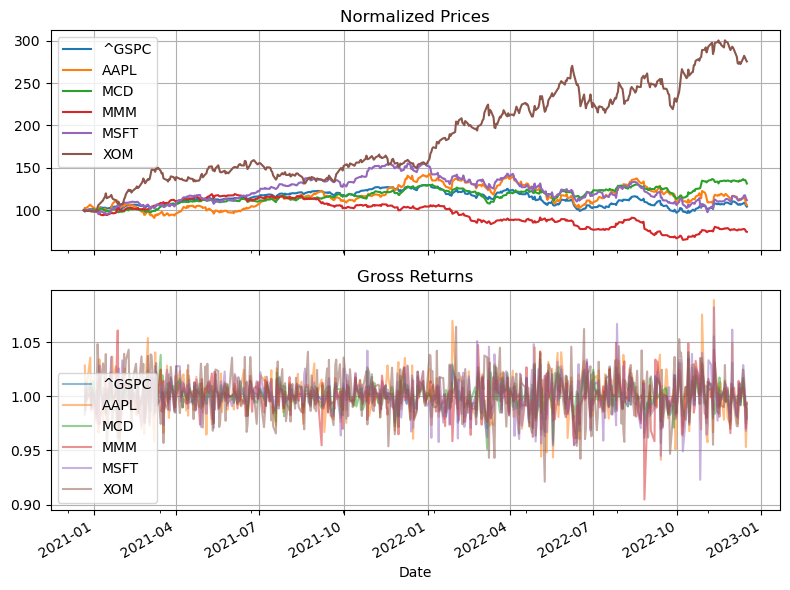

In [11]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
S.divide(S.iloc[0]/100).plot(ax=ax[0], grid=True, title="Normalized Prices")
R.plot(ax=ax[1], grid=True, title="Gross Returns", alpha=0.5)
fig.tight_layout()

### Pyomo Implementation

The Pyomo implementation for the risk-constrained Kelly portfolio accepts three parameters, the risk-free gross returns $R_f$, the maximum equity multiplier, and the risk-aversion parameter.


Risk Free Return = 5.00 %
Equity Multiplier Limit = 2.00000
Risk Aversion = 10.00000

Portfolio
^GSPC    S&P 500 Index                       0.00 %
AAPL     Apple                               0.00 %
MCD      McDonald's                         37.92 %
MMM      3 M                                 0.00 %
MSFT     Microsoft                           0.00 %
XOM      ExxonMobil                         85.02 %
         Risk Free                         -22.94 %

Annualized return = 61.92 %


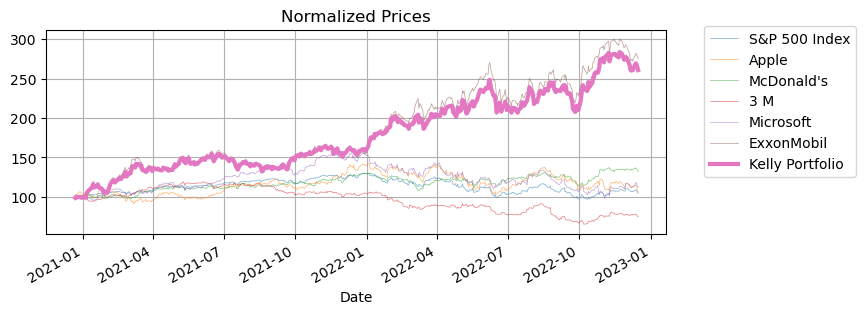

In [12]:
def kelly_portfolio(R, Rf=1, EM=1, lambd=0):

    m = pmo.block()
    
    # return parameters with the model
    m.Rf = Rf
    m.EM = EM
    m.lambd = lambd
    
    # index lists
    m.T = R.index
    m.N = R.columns
    
    # decision variables
    m.q = pmo.variable_dict({t: pmo.variable() for t in m.T})
    m.w = pmo.variable_dict({n: pmo.variable(lb=0) for n in m.N})

    # objective
    m.ElogR = pmo.objective(sum(m.q[t] for t in m.T)/len(m.T), sense=pmo.maximize)

    # conic constraints on return
    m.R = pmo.expression_dict({t: pmo.expression(Rf + sum(m.w[n]*(R.loc[t, n] - Rf) for n in m.N)) for t in m.T})
    m.c = pmo.block_dict({t:pmo.conic.primal_exponential.as_domain(m.R[t], 1, m.q[t]) for t in m.T})

    # risk constraints
    m.u = pmo.variable_dict({t: pmo.variable() for t in m.T})
    m.u_sum = pmo.constraint(sum(m.u[t] for t in m.T)/len(m.T) <= Rf**(-lambd))
    m.r = pmo.block_dict({t:pmo.conic.primal_exponential.as_domain(m.u[t], 1, -lambd*m.q[t]) for t in m.T})
    
    # equity multiplier constraint
    m.w_sum = pmo.constraint(sum(m.w[n] for n in m.N) <= EM)

    pmo.SolverFactory('mosek_direct').solve(m)
    
    return m

def kelly_report(m):
    s = ""
    #print report
    s += f"\nRisk Free Return = {100*(np.exp(252*np.log(m.Rf)) - 1):0.2f} %"
    s += f"\nEquity Multiplier Limit = {m.EM:0.5f}"
    s += f"\nRisk Aversion = {m.lambd:0.5f}"
    s += "\n\nPortfolio"
    s += "\n"
    s += "\n".join([f"{n:8s} {symbols[n]:30s}  {100*m.w[n]():8.2f} %" for n in m.N])
    s += f"\n{'':8s} {'Risk Free':30s}  {100*(1 - sum(m.w[n]() for n in R.columns)):8.2f} %"
    s += f"\n\nAnnualized return = {100*(np.exp(252*m.ElogR()) - 1):0.2f} %"
    print(s)
    
    df = pd.DataFrame(pd.Series([m.R[t]() for t in m.T]), columns=["Kelly Portfolio"])
    df.index = m.T
    
    fix, ax = plt.subplots(1, 1, figsize=(8, 3))
    S.divide(S.iloc[0]/100).plot(ax=ax, grid=True, title="Normalized Prices", alpha=0.6, lw=0.5)
    df.cumprod().multiply(100).plot(ax=ax, lw=3, grid=True)
    ax.legend([symbols[n] for n in m.N] + ["Kelly Portfolio"], bbox_to_anchor=(1.05, 1.05))

   
# parameter values
Rf = Rf=np.exp(np.log(1.05)/252)
EM = 2
lambd = 10

m = kelly_portfolio(R, Rf, EM, lambd)
kelly_report(m)

### Effects of the Risk-Aversion Parameter

In [13]:
lambd = 10**np.linspace(0, 3)

results = [kelly_portfolio(R, Rf=1, EM=1, lambd=_) for _ in lambd]

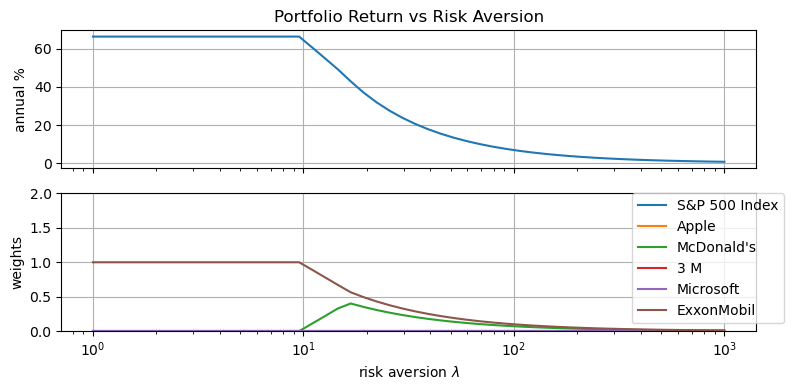

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax[0].semilogx([m.lambd for m in results], [100*(np.exp(252*m.ElogR()) - 1) for m in results])
ax[0].set_title('Portfolio Return vs Risk Aversion')
ax[0].set_ylabel("annual %")
ax[0].grid(True)

ax[1].semilogx([m.lambd for m in results], [[m.w[n]() for n in R.columns] for m in results])
ax[1].set_ylabel('weights')
ax[1].set_xlabel('risk aversion $\lambda$')
ax[1].legend([symbols[n] for n in m.N], bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, EM)

fig.tight_layout()

### Effects of the Equity Multiplier Parameter

In [15]:
EM = np.linspace(0.0, 2.0)

results = [kelly_portfolio(R, Rf=1, EM=_, lambd=10) for _ in EM]

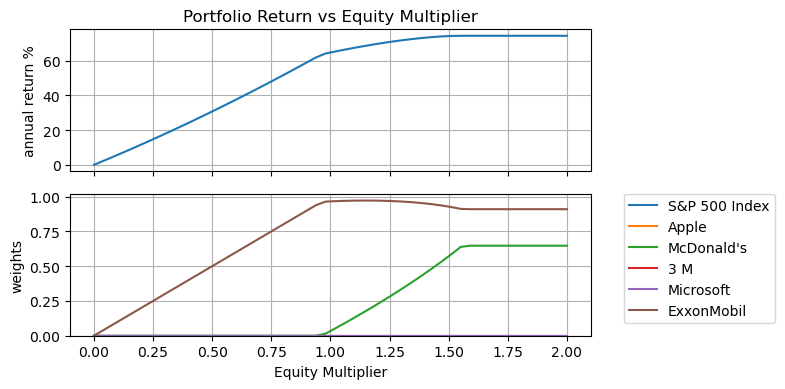

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax[0].plot([m.EM for m in results], [100*(np.exp(252*m.ElogR()) - 1) for m in results])
ax[0].set_title('Portfolio Return vs Equity Multiplier')
ax[0].set_ylabel("annual return %")
ax[0].grid(True)

ax[1].plot([m.EM for m in results], [[m.w[n]() for n in R.columns] for m in results])
ax[1].set_ylabel('weights')
ax[1].set_xlabel('Equity Multiplier')
ax[1].legend([symbols[n] for n in m.N], bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, )

fig.tight_layout()

### Effect of Risk-free Interest Rate

In [17]:
Rf = np.exp(np.log(1 + np.linspace(0, 0.20))/252)

results = [kelly_portfolio(R, Rf=_, EM=1, lambd=10) for _ in Rf]

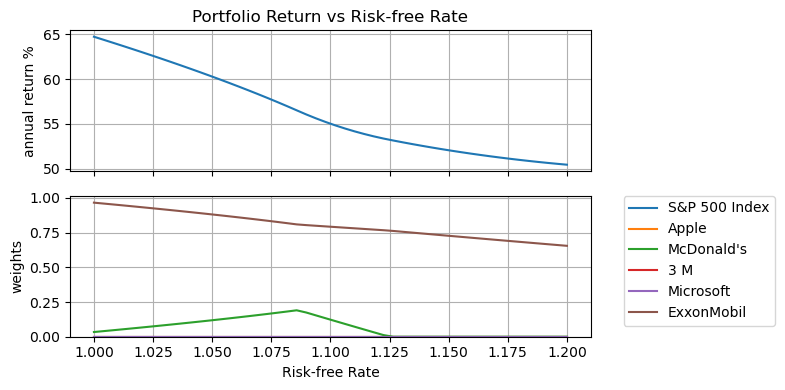

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

Rf = np.exp(252*np.log(np.array([_.Rf for _ in results])))
ax[0].plot(Rf, [100*(np.exp(252*m.ElogR()) - 1) for m in results])
ax[0].set_title('Portfolio Return vs Risk-free Rate')
ax[0].set_ylabel("annual return %")
ax[0].grid(True)

ax[1].plot(Rf, [[m.w[n]() for n in R.columns] for m in results])
ax[1].set_ylabel('weights')
ax[1].set_xlabel('Risk-free Rate')
ax[1].legend([symbols[n] for n in m.N], bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, )

fig.tight_layout()

## Extensions

1. The examples cited in this notebook assume knowledge of the probability mass distribution. Recent work by Sun and Boyd (2018) and Hsieh (2022) suggest models for finding investment strategies for cases where the distributions are not perfectly known. They call the "distributional robust Kelly gambling." A useful extension to this notebook would be to demonstrate a robust solution to one or more of the examples.

## Bibliographic Notes

The Kelly Criterion has been included in many tutorial introductions to finance and probability, and the subject of popular accounts.

> Poundstone, W. (2010). Fortune's formula: The untold story of the scientific betting system that beat the casinos and Wall Street. Hill and Wang. https://www.onlinecasinoground.nl/wp-content/uploads/2020/10/Fortunes-Formula-boek-van-William-Poundstone-oa-Kelly-Criterion.pdf

> Thorp, E. O. (2017). A man for all markets: From Las Vegas to wall street, how i beat the dealer and the market. Random House.

> Thorp, E. O. (2008). The Kelly criterion in blackjack sports betting, and the stock market. In Handbook of asset and liability management (pp. 385-428). North-Holland. https://www.palmislandtraders.com/econ136/thorpe_kelly_crit.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2010). Good and bad properties of the Kelly criterion. Risk, 20(2), 1.  https://www.stat.berkeley.edu/~aldous/157/Papers/Good_Bad_Kelly.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2011). The Kelly capital growth investment criterion: Theory and practice (Vol. 3). world scientific. https://www.worldscientific.com/worldscibooks/10.1142/7598#t=aboutBook

>  https://en.wikipedia.org/wiki/Kelly_criterion

Luenberger's investment wheel is 

> Luenberger, D. (2009). Investment science: International edition. OUP Catalogue.  https://global.oup.com/ushe/product/investment-science-9780199740086


The utility of conic programming to solve problems involving log growth is more recent. Here are some representative papers.

> Cajas, D. (2021). Kelly Portfolio Optimization: A Disciplined Convex Programming Framework. Available at SSRN 3833617. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3833617

> Busseti, E., Ryu, E. K., & Boyd, S. (2016). Risk-constrained Kelly gambling. The Journal of Investing, 25(3), 118-134. https://arxiv.org/pdf/1603.06183.pdf


> Fu, A., Narasimhan, B., & Boyd, S. (2017). CVXR: An R package for disciplined convex optimization. arXiv preprint arXiv:1711.07582. https://arxiv.org/abs/1711.07582

> Sun, Q., & Boyd, S. (2018). Distributional robust Kelly gambling. arXiv preprint arXiv: 1812.10371. https://web.stanford.edu/~boyd/papers/pdf/robust_kelly.pdf

The recent work by CH Hsieh extends these concepts in important ways for real-world implementation.

> Hsieh, C. H. (2022). On Solving Robust Log-Optimal Portfolio: A Supporting Hyperplane Approximation Approach. arXiv preprint arXiv:2202.03858. https://arxiv.org/pdf/2202.03858
